# Immigration Analytics
### Data Engineering Capstone Project

#### Project Summary
The project consists in develop a Fact Table with the data sources provided by Udacity Provided Project. The technologies involved were Pandas, Spark, Fbprohet and Matplotlib.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json
import statsmodels.api as sm
from fbprophet import Prophet
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
# Reading usefull data por code equivalences
util_data = json.load(open('utils.json','r'))
us_state_code = util_data['us_state_code']
us_code_state = {v: k for k, v in us_state_code.items()}
city_codes = util_data['city_codes']
immigration_codes = util_data['immigration_codes']

In [3]:
# Starting Spark Session
from pyspark.sql import SparkSession, SQLContext, GroupedData
from pyspark.sql.functions import *
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

In [4]:
# Starting Spark SQL
sqlContext = SQLContext(spark)
sqlContext.setConf("spark.sql.autoBroadcastJoinThreshold", "0")

In [5]:
# Getting UDF for Spark SQL
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

state_codeUDF=udf(lambda x: us_state_code[x],StringType())
code_stateUDF=udf(lambda x: us_code_state[x],StringType())
city_codeUDF=udf(lambda x:city_codes[x],StringType())
country_codeUDF=udf(lambda x: immigration_codes[x],StringType())

### Step 1: Scope the Project and Gather Data

#### Scope 

* This Capstone Project will create Dimesion and Fact Tables from raw data provided from 4 differents data sources to create a final Fact Table that shows the Number of immigrants per country and which state they go and from which airport they come.

#### Describe and Gather Data 
* **I94 Immigration Data:** comes from the US National Tourism and Trade Office and includes details on incoming immigrants and their ports of entry. [Here](https://travel.trade.gov/research/reports/i94/historical/2016.html)
* **World Temperature Data:** comes from kaggle and includes data on temperature changes in the U.S. since 1850. [Here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)
* **U.S. City Demographic Data:** comes from OpenSoft and includes data by city, state, age, population, veteran status and race. [Here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)
* **Airport Code Table:** comes from datahub.io and includes airport codes and corresponding cities. [Here](https://datahub.io/core/airport-codes#data)

In [15]:
# Reading data sources, the data for immigration will be read later using Spark
df_airport = pd.read_csv("airport-codes_csv.csv")
df_demographics = pd.read_csv("us-cities-demographics.csv",sep=';')
df_temperature = pd.read_csv("../GlobalLandTemperaturesByState.csv")

### Step 2: Explore and Assess the Data
#### Explore the Data 
* In the case of the Temperature Data Source, it has only data until the 2013, so I will predict the data per state until 2016 to aggregate it with the data from Immigration that has only data from 2016.
* In the case of the Immigration Data Source, it has several files, so it would be better to use Spark for better performance.

#### Cleaning Steps

* Temperature:
    1. Filter the data since 1900.
    2. Predict the Average Temperature until 2017 per State.
    3. Write the Dimension Table into a CSV file.

* Immigration:
    1. Read every file per month into a Spark DataFrame.
    2. Filter the missing values.
    3. Generate the corresponding names and codes per state and city using UDF.
    4. Write the Dimesion Table into Parquet.

* Demographics:
    1. Transform the Race values into shorter values.
    2. Get the Average and Sum values per State
    3. Get percentages per Columns.
    4. Get percentages per Race.
    5. Write the Dimension Table into a CSV file.
    
* Airports:
    1. Filter USA data.
    2. Filter Airport data.
    3. Transform data types for several columns.
    4. Write the Dimension Table into a CSV file.
    

### Temperature data for every state in U.S.A.

In [16]:
df_temperature.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [17]:
import datetime
df_temperature['dt'] = pd.to_datetime(df_temperature['dt'])
df_temperature['year'] = df_temperature['dt'].dt.year
df_temperature['month'] = df_temperature['dt'].dt.month


In [18]:
df_temperature['year'].max()

2013

#### Predict temperature data until 2016
The maximum year in the dataset is 2013, so I need to make a prediction until 2016 using the historical data, to aggregate this data with the immigration data.

In [19]:
df_temperature['y'] = df_temperature['AverageTemperature']
df_temperature['ds'] = df_temperature['dt']

In [20]:
us_df_temperature = df_temperature[(df_temperature["Country"]=="United States")&(df_temperature['year'] > 1900)]

In [21]:
us_df_temperature['state_code'] = us_df_temperature.apply(lambda row: us_state_code[row["State"]],axis=1)
us_df_temperature = us_df_temperature[['dt','AverageTemperature','State','Country','year','month','state_code','y','ds']]


In [22]:
us_df_temperature.head(20)

,dt,AverageTemperature,State,Country,year,month,state_code,y,ds
9344,1901-01-01,7.603,Alabama,United States,1901,1,AL,7.603,1901-01-01
9345,1901-02-01,6.040,Alabama,United States,1901,2,AL,6.040,1901-02-01
9346,1901-03-01,11.596,Alabama,United States,1901,3,AL,11.596,1901-03-01
9347,1901-04-01,13.865,Alabama,United States,1901,4,AL,13.865,1901-04-01
9348,1901-05-01,20.816,Alabama,United States,1901,5,AL,20.816,1901-05-01
9349,1901-06-01,25.423,Alabama,United States,1901,6,AL,25.423,1901-06-01
9350,1901-07-01,27.414,Alabama,United States,1901,7,AL,27.414,1901-07-01
9351,1901-08-01,25.456,Alabama,United States,1901,8,AL,25.456,1901-08-01
9352,1901-09-01,21.989,Alabama,United States,1901,9,AL,21.989,1901-09-01
9353,1901-10-01,16.540,Alabama,United States,1901,10,AL,16.540,1901-10-01


#### Example for Alabama State

In [23]:
alabama_temperature_df = us_df_temperature[(us_df_temperature["state_code"]=="AL")&(df_temperature['year'] > 2000)]

In [24]:
alabama_temperature_df.head()

,dt,AverageTemperature,State,Country,year,month,state_code,y,ds
10544,2001-01-01,5.358,Alabama,United States,2001,1,AL,5.358,2001-01-01
10545,2001-02-01,11.583,Alabama,United States,2001,2,AL,11.583,2001-02-01
10546,2001-03-01,11.185,Alabama,United States,2001,3,AL,11.185,2001-03-01
10547,2001-04-01,18.517,Alabama,United States,2001,4,AL,18.517,2001-04-01
10548,2001-05-01,21.985,Alabama,United States,2001,5,AL,21.985,2001-05-01


In [25]:
alabama_temperature_df['ds'] = alabama_temperature_df['dt']
alabama_temperature_df['y'] = alabama_temperature_df['AverageTemperature']

In [26]:
alabama_temperature_df.head(20)

,dt,AverageTemperature,State,Country,year,month,state_code,y,ds
10544,2001-01-01,5.358,Alabama,United States,2001,1,AL,5.358,2001-01-01
10545,2001-02-01,11.583,Alabama,United States,2001,2,AL,11.583,2001-02-01
10546,2001-03-01,11.185,Alabama,United States,2001,3,AL,11.185,2001-03-01
10547,2001-04-01,18.517,Alabama,United States,2001,4,AL,18.517,2001-04-01
10548,2001-05-01,21.985,Alabama,United States,2001,5,AL,21.985,2001-05-01
10549,2001-06-01,24.904,Alabama,United States,2001,6,AL,24.904,2001-06-01
10550,2001-07-01,27.066,Alabama,United States,2001,7,AL,27.066,2001-07-01
10551,2001-08-01,26.443,Alabama,United States,2001,8,AL,26.443,2001-08-01
10552,2001-09-01,22.766,Alabama,United States,2001,9,AL,22.766,2001-09-01
10553,2001-10-01,16.343,Alabama,United States,2001,10,AL,16.343,2001-10-01


#### Temperature Model Prediction using Prophet
Prophet is a predictive model for time series that use seasonality

In [27]:
temperature_model = Prophet(interval_width=0.95)
temperature_model.fit(alabama_temperature_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
temperature_forecast = temperature_model.make_future_dataframe(periods=50, freq='MS')
temperature_forecast = temperature_model.predict(temperature_forecast)

<Figure size 1296x432 with 0 Axes>

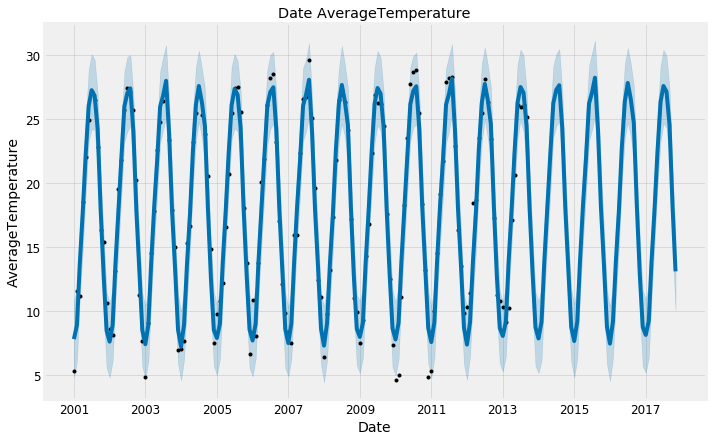

In [29]:
plt.figure(figsize=(18, 6))
temperature_model.plot(temperature_forecast, xlabel = 'Date', ylabel = 'AverageTemperature')
plt.title('Date AverageTemperature');

In [30]:
temperature_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,17.808159,4.837372,10.906686,17.808159,17.808159,-9.998029,-9.998029,-9.998029,-9.998029,-9.998029,-9.998029,0.0,0.0,0.0,7.810130
1,2001-02-01,17.810006,6.078086,11.553477,17.810006,17.810006,-8.899549,-8.899549,-8.899549,-8.899549,-8.899549,-8.899549,0.0,0.0,0.0,8.910457
2,2001-03-01,17.811675,10.921031,16.423956,17.811675,17.811675,-4.273057,-4.273057,-4.273057,-4.273057,-4.273057,-4.273057,0.0,0.0,0.0,13.538618
3,2001-04-01,17.813522,14.678359,20.294024,17.813522,17.813522,-0.157901,-0.157901,-0.157901,-0.157901,-0.157901,-0.157901,0.0,0.0,0.0,17.655621
4,2001-05-01,17.815310,19.134096,24.737962,17.815310,17.815310,4.332257,4.332257,4.332257,4.332257,4.332257,4.332257,0.0,0.0,0.0,22.147567
5,2001-06-01,17.817157,23.268868,28.844669,17.817157,17.817157,8.180926,8.180926,8.180926,8.180926,8.180926,8.180926,0.0,0.0,0.0,25.998083
6,2001-07-01,17.818945,24.195259,30.036697,17.818945,17.818945,9.415947,9.415947,9.415947,9.415947,9.415947,9.415947,0.0,0.0,0.0,27.234892
7,2001-08-01,17.820792,24.137469,29.614595,17.820792,17.820792,8.969496,8.969496,8.969496,8.969496,8.969496,8.969496,0.0,0.0,0.0,26.790289
8,2001-09-01,17.822640,21.186114,26.952039,17.822640,17.822640,6.352112,6.352112,6.352112,6.352112,6.352112,6.352112,0.0,0.0,0.0,24.174751
9,2001-10-01,17.824428,15.203161,20.766463,17.824428,17.824428,0.123721,0.123721,0.123721,0.123721,0.123721,0.123721,0.0,0.0,0.0,17.948149


In [31]:
def get_temperature_prediction(df):
    temperature_model = Prophet(interval_width=0.95)
    temperature_model.fit(df)
    temperature_forecast = temperature_model.make_future_dataframe(periods=50, freq='MS')
    temperature_forecast = temperature_model.predict(temperature_forecast)
    temperature_forecast['year'] = temperature_forecast['ds'].dt.year
    temperature_forecast['month'] = temperature_forecast['ds'].dt.month
    temperature_forecast['AverageTemperature'] = temperature_forecast['yhat']
    return temperature_forecast[['year','month','AverageTemperature']]

In [32]:
us_temperature_pred_df = pd.DataFrame(columns=['year','month','AverageTemperature','state_code','state','country'])

In [33]:
for state_code,state in us_code_state.items():
    print(state_code,state)
    try:
        df = us_df_temperature[us_df_temperature["state_code"]==state_code].copy()
        df = get_temperature_prediction(df)
        df = df[df['year'] > 2010]
        df['state_code'] = state_code
        df['state'] = state
        df['country'] = 'United States'
        us_temperature_pred_df = us_temperature_pred_df.append(df,ignore_index=True)
    except Exception as e:
        print(e)
        continue

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AL Alabama


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AK Alaska


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AZ Arizona


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AR Arkansas


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CA California


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CO Colorado


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CT Connecticut


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DE Delaware


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DC District Of Columbia


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FL Florida


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GA Georgia (State)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HI Hawaii


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ID Idaho


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IL Illinois


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IN Indiana


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IA Iowa


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KS Kansas


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KY Kentucky


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LA Louisiana


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ME Maine


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MD Maryland


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MA Massachusetts


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MI Michigan


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MN Minnesota


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MS Mississippi


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MO Missouri


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MT Montana


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NE Nebraska


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NV Nevada


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NH New Hampshire


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NJ New Jersey


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NM New Mexico


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NY New York


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NC North Carolina


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ND North Dakota


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MP Northern Mariana Islands
Dataframe has less than 2 non-NaN rows.
OH Ohio


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OK Oklahoma


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OR Oregon


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PW Palau
Dataframe has less than 2 non-NaN rows.
PA Pennsylvania


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PR Puerto Rico
Dataframe has less than 2 non-NaN rows.
RI Rhode Island


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SC South Carolina


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SD South Dakota


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TN Tennessee


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TX Texas


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UT Utah


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VT Vermont


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VI Virgin Islands
Dataframe has less than 2 non-NaN rows.
VA Virginia


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WA Washington


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WV West Virginia


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WI Wisconsin


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WY Wyoming


In [34]:
us_temperature_pred_df[us_temperature_pred_df['year'] == 2016].head(20)

,year,month,AverageTemperature,state_code,state,country
60,2016,1,7.627353,AL,Alabama,United States
61,2016,2,9.652699,AL,Alabama,United States
62,2016,3,13.667808,AL,Alabama,United States
63,2016,4,17.730063,AL,Alabama,United States
64,2016,5,22.218922,AL,Alabama,United States
65,2016,6,26.334528,AL,Alabama,United States
66,2016,7,27.627276,AL,Alabama,United States
67,2016,8,27.070328,AL,Alabama,United States
68,2016,9,24.541355,AL,Alabama,United States
69,2016,10,18.041728,AL,Alabama,United States


In [35]:
us_temperature_pred_df.to_csv("us_temperature.csv",index=False)

### Immigration data for every state in U.S.A.
This dataset is splitted in 12 files for every month in 2016. The format for every file comes from SAS and are quite big files, so for a fast process, I will use Spark

In [36]:
months = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
fname = '../18-83510-I94-Data-2016/i94_{}16_sub.sas7bdat'

In [37]:
for month in months:
    filename = fname.format(month)
    print(filename)
    immigrationDF = spark.read.format('com.github.saurfang.sas.spark').load(filename)
    
    immigrationMonthDF=immigrationDF.filter(immigrationDF.i94addr.isNotNull())\
    .filter(immigrationDF.i94res.isNotNull())\
    .filter(col("i94addr").isin(list(us_code_state.keys())))\
    .filter(col("i94port").isin(list(city_codes.keys())))\
    .withColumn("i94res",col("i94res").cast("integer").cast("string"))\
    .withColumn("origin_country",country_codeUDF(col("i94res")))\
    .withColumn("State",code_stateUDF(col("i94addr")))\
    .withColumn("id",col("cicid").cast("integer"))\
    .withColumn("state_code",col("i94addr"))\
    .withColumn("city_code",col("i94port"))\
    .withColumn("year",col("i94yr").cast("integer"))\
    .withColumn("month",col("i94mon").cast("integer"))\
    .withColumn("city",city_codeUDF(col("i94port")))
                                  
    immigrationMonthDF.select('id','year','month','origin_country','city_code','city','state_code','State').write.mode('append').parquet('immigration_data')
    

../18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_feb16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_mar16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_may16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_jul16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_aug16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_sep16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_oct16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_nov16_sub.sas7bdat
../18-83510-I94-Data-2016/i94_dec16_sub.sas7bdat


### U.S. Demographic Data by State

In [38]:
df_demographics.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [39]:
df_demographics.loc[df_demographics["Race"] == "American Indian and Alaska Native","Race"] = "Native"
df_demographics.loc[df_demographics["Race"] == "Black or African-American","Race"] = "Afroamerican"
df_demographics.loc[df_demographics["Race"] == "Hispanic or Latino","Race"] = "Latino"

In [40]:
us_demographics_avg_df = df_demographics.groupby(['State','State Code','Race'])['Median Age'].mean()
us_demographics_sum_df = df_demographics.groupby(['State','State Code','Race'])['Total Population','Count','Male Population','Female Population','Number of Veterans','Foreign-born'].sum()

In [41]:
us_demographics_df = pd.concat([us_demographics_sum_df,us_demographics_avg_df],axis=1)
us_demographics_df.reset_index(inplace=True)
us_demographics_df["state_code"] = us_demographics_df["State Code"]
us_demographics_df["median_age"] = us_demographics_df["Median Age"]

In [42]:
for state_code in us_code_state:
    print(state_code)
    df = us_demographics_df.loc[us_demographics_df['state_code'] == state_code]
    total_population = df['Total Population'].max()
    male_population = df['Male Population'].max()
    female_population = df['Female Population'].max()
    veterans_population = df['Number of Veterans'].max()
    foreign_population = df['Foreign-born'].max()
    median_age = df['median_age'].max()
    
    us_demographics_df.loc[us_demographics_df['state_code'] == state_code,'Total Population'] = total_population
    us_demographics_df.loc[us_demographics_df['state_code'] == state_code,'Male Population'] = male_population
    us_demographics_df.loc[us_demographics_df['state_code'] == state_code,'Female Population'] = female_population
    us_demographics_df.loc[us_demographics_df['state_code'] == state_code,'Number of Veterans'] = veterans_population
    us_demographics_df.loc[us_demographics_df['state_code'] == state_code,'Foreign-born'] = foreign_population
    us_demographics_df.loc[us_demographics_df['state_code'] == state_code,'median_age'] = median_age

AL
AK
AZ
AR
CA
CO
CT
DE
DC
FL
GA
HI
ID
IL
IN
IA
KS
KY
LA
ME
MD
MA
MI
MN
MS
MO
MT
NE
NV
NH
NJ
NM
NY
NC
ND
MP
OH
OK
OR
PW
PA
PR
RI
SC
SD
TN
TX
UT
VT
VI
VA
WA
WV
WI
WY


In [43]:
us_demographics_df["percentage_male"] = us_demographics_df.apply(lambda row: float(row["Male Population"]/row["Total Population"])*100.0,axis=1)
us_demographics_df["percentage_female"] = us_demographics_df.apply(lambda row: float(row["Female Population"]/row["Total Population"])*100.0,axis=1)
us_demographics_df["percentage_veterans"] = us_demographics_df.apply(lambda row: float(row["Number of Veterans"]/row["Total Population"])*100.0,axis=1)
us_demographics_df["percentage_foreign_born"] = us_demographics_df.apply(lambda row: float(row["Foreign-born"]/row["Total Population"])*100.0,axis=1)
us_demographics_df["percentage_race"] = us_demographics_df.apply(lambda row: float(row["Count"]/row["Total Population"])*100.0,axis=1)


In [44]:
us_df_demographics = pd.pivot_table(us_demographics_df,values='percentage_race',index=["State","state_code","median_age","percentage_male","percentage_female","percentage_veterans","percentage_foreign_born"],columns=["Race"], aggfunc=np.mean, fill_value=0)
us_df_demographics = pd.DataFrame(us_df_demographics.to_records())

In [46]:
us_df_demographics

,State,state_code,median_age,percentage_male,percentage_female,percentage_veterans,percentage_foreign_born,Afroamerican,Asian,Latino,Native,White
0,Alabama,AL,36.228571,47.373691,52.626309,6.816027,4.968803,49.643064,2.740873,3.745419,0.770177,47.532985
1,Alaska,AK,32.200000,51.204406,48.795594,9.204038,11.134435,7.735985,12.328630,9.126701,12.165922,71.208423
2,Arizona,AZ,35.037500,49.504038,50.495962,5.878487,15.164054,6.583381,5.093474,33.518011,2.882693,79.821702
3,Arkansas,AR,32.766667,48.565723,51.434277,5.374662,10.528939,25.362490,3.740089,13.191349,1.590326,65.222359
4,California,CA,36.226471,49.464400,50.535600,3.739637,30.006119,8.246600,18.304914,39.707845,1.617027,60.046945
5,Colorado,CO,35.818750,49.549830,50.450170,6.400449,11.500990,7.086732,5.068351,23.971435,2.132836,83.930307
6,Connecticut,CT,35.185714,48.799263,51.200737,2.817698,25.504838,26.177391,5.455289,35.004364,1.211521,57.100819
7,Delaware,DE,36.400000,45.416012,54.583988,4.256709,4.636102,61.400559,1.657935,7.665689,0.575344,32.996095
8,District of Columbia,DC,33.800000,47.559013,52.440987,3.862231,14.149515,48.909894,5.217277,10.581083,0.911893,42.456131
9,Florida,FL,39.666667,47.622448,51.309540,5.711975,24.849141,24.314885,3.897943,28.572854,0.687962,70.006288


In [47]:
us_df_demographics.to_csv("us_demographics.csv",index=False)

### U.S. Airport Data by State 

In [48]:
df_airport.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [49]:
us_df_airport = df_airport[df_airport["iso_country"]=="US"]
us_df_airport = us_df_airport[(us_df_airport["type"]=="small_airport")|(us_df_airport["type"]=="medium_airport")|(us_df_airport["type"]=="large_airport")]

In [50]:
us_df_airport["elevation_ft"] = us_df_airport.apply(lambda row: float(row["elevation_ft"]),axis=1)
us_df_airport["state_code"] = us_df_airport.apply(lambda row: row["iso_region"].split("-")[-1],axis=1)
us_df_airport["x_coordinate"] = us_df_airport.apply(lambda row: float(row["coordinates"].split(",")[0]),axis=1)
us_df_airport["y_coordinate"] = us_df_airport.apply(lambda row: float(row["coordinates"].split(",")[-1]),axis=1)

In [51]:
us_df_airport["country"] = us_df_airport["iso_country"]
us_df_airport["city_code"] = us_df_airport["local_code"]
us_df_airport = us_df_airport[["ident","type","name","elevation_ft","country","state_code","city_code","municipality","x_coordinate","y_coordinate"]]

In [53]:
us_df_airport.head()

,ident,type,name,elevation_ft,country,state_code,city_code,municipality,x_coordinate,y_coordinate
1,00AA,small_airport,Aero B Ranch Airport,3435.0,US,KS,00AA,Leoti,-101.473911,38.704022
2,00AK,small_airport,Lowell Field,450.0,US,AK,00AK,Anchor Point,-151.695999,59.949200
3,00AL,small_airport,Epps Airpark,820.0,US,AL,00AL,Harvest,-86.770302,34.864799
5,00AS,small_airport,Fulton Airport,1100.0,US,OK,00AS,Alex,-97.818019,34.942803
6,00AZ,small_airport,Cordes Airport,3810.0,US,AZ,00AZ,Cordes,-112.165001,34.305599


In [54]:
us_df_airport.to_csv("us_airports.csv",index=False)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

The data model chosen is Star Schema because it's a simple schema that can be easily ingested and still being used in analytics.

**Star Schema**

1. Dimension Tables
    * Temperature
    * Immigration
    * Demographics
    * Airports
2. Fact Table
    * Fact_Immigration

<img src="DEND_DATA_DICTIONARY.png">

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

    1. Dimension tables will be ingested from the raw data that is cleaned and transformed as the previous cells.
    2. Every dimension table will be read by Spark and a TempView will be created for every table.
    3. Spark SQL will be used to create the Fact Table, because SQL syntax is easier than use DataFrame joins.
    4. Fact table generated will be stored in a parquet file.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [70]:
# Read every Dimension table
temperatureDF = spark.read.csv("us_temperature.csv",header=True)
demographicsDF = spark.read.csv("us_demographics.csv",header=True)
airportsDF = spark.read.csv("us_airports.csv",header=True)
immigrationDF = spark.read.parquet("immigration_data")

In [71]:
# For time processing purposes, I will be using only the first 6 months in the immigration dataframe
immigrationDF = immigrationDF.filter(col("month")<lit(7))

In [72]:
# Create Dimension TempViews
temperatureDF.createOrReplaceTempView("temperature")
immigrationDF.createOrReplaceTempView("immigration")
demographicsDF.createOrReplaceTempView("demographics")
airportsDF.createOrReplaceTempView("airports")

In [10]:
# Running SQL Procedure to get the fact table dataframe
fact_table = spark.sql("""
    SELECT 
        immig.year,
        immig.month,
        immig.origin_country,
        immig.State,
        immig.state_code,
        COUNT(immig.state_code) as number_immigrants,
        temp.AverageTemperature as avg_temperature,
        demo.median_age,
        demo.percentage_male,
        demo.percentage_female,
        demo.percentage_veterans,
        demo.percentage_foreign_born,
        demo.Afroamerican as percentage_afroamerican,
        demo.Asian as percentage_asian,
        demo.Latino as percentage_latino,
        demo.Native as percentage_native,
        demo.White as percentage_white,
        air.name as airport_name,
        air.x_coordinate,
        air.y_coordinate
    FROM immigration immig
    JOIN temperature temp ON immig.state_code=temp.state_code AND immig.year=temp.year AND immig.month=temp.month
    JOIN demographics demo ON demo.state_code=immig.state_code
    JOIN airports air ON air.state_code=immig.state_code
    WHERE air.type='large_airport'
    GROUP BY 1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20
    ORDER BY 1,2,3,4
""").cache()

In [11]:
# Count rows in dataframe
fact_table.count()

167513

In [12]:
fact_table.show()

+----+-----+--------------+----------+----------+-----------------+------------------+-----------------+------------------+------------------+-------------------+-----------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+
|year|month|origin_country|     State|state_code|number_immigrants|   avg_temperature|       median_age|   percentage_male| percentage_female|percentage_veterans|percentage_foreign_born|     Afroamerican|             Asian|            Latino|            Native|             White|        airport_name|       x_coordinate|      y_coordinate|
+----+-----+--------------+----------+----------+-----------------+------------------+-----------------+------------------+------------------+-------------------+-----------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------

In [13]:
# Write Fact Table in Parquet format
fact_table.write.mode('overwrite').parquet("fact_table")

# 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [59]:
fact_table = spark.read.parquet("fact_table")

In [65]:
fact_table.createOrReplaceTempView("fact_table")

In [64]:
# Test case: Check null values per column
test_case_1 = fact_table.select(isnull('year'),\
                  isnull('month'),\
                  isnull('origin_country'),\
                  isnull('state_code'),\
                  isnull('State')).dropDuplicates()
test_case_1.show()

+--------------+---------------+------------------------+--------------------+---------------+
|(year IS NULL)|(month IS NULL)|(origin_country IS NULL)|(state_code IS NULL)|(State IS NULL)|
+--------------+---------------+------------------------+--------------------+---------------+
|         false|          false|                   false|               false|          false|
+--------------+---------------+------------------------+--------------------+---------------+



In [95]:
# Test Case: Check Sum for number of immigrants equal to 0
test_case_2 = spark.sql("""
    SELECT A.State, A.state_code, A.sum_immigrants
    FROM (
        SELECT State, state_code, SUM(number_immigrants) as sum_immigrants
        FROM fact_table
        GROUP BY 1,2
        ORDER BY 1,2
    ) A
    WHERE A.sum_immigrants=0
""")

In [96]:
test_case_2.show()

+-----+----------+--------------+
|State|state_code|sum_immigrants|
+-----+----------+--------------+
+-----+----------+--------------+



In [97]:
immigrationDF.show()

+-------+----+-----+--------------------+---------+--------------------+----------+----------+
|     id|year|month|      origin_country|city_code|                city|state_code|     State|
+-------+----+-----+--------------------+---------+--------------------+----------+----------+
|6223412|2016|    6|MEXICO Air Sea, a...|      XXX|NOT REPORTED/UNKN...|        CA|California|
|6223423|2016|    6|MEXICO Air Sea, a...|      XXX|NOT REPORTED/UNKN...|        NV|    Nevada|
|6223450|2016|    6|MEXICO Air Sea, a...|      XXX|NOT REPORTED/UNKN...|        CA|California|
|6223510|2016|    6|MEXICO Air Sea, a...|      XXX|NOT REPORTED/UNKN...|        TX|     Texas|
|6223511|2016|    6|MEXICO Air Sea, a...|      XXX|NOT REPORTED/UNKN...|        NV|    Nevada|
|6223574|2016|    6|MEXICO Air Sea, a...|      XXX|NOT REPORTED/UNKN...|        CA|California|
|6223580|2016|    6|MEXICO Air Sea, a...|      XXX|NOT REPORTED/UNKN...|        TX|     Texas|
|6223601|2016|    6|MEXICO Air Sea, a...|      XXX

In [105]:
# Test Case: Check if there are immigrants that were no copied from the original immigrants dimensional table
test_case_3 = spark.sql("""
    SELECT I.year, I.month, I.State, I.state_code
    FROM (
        SELECT year, month, State, state_code, COUNT(state_code) as number_immigrants
        FROM immigration
        GROUP BY 1,2,3,4
        ORDER BY 1,2,3,4
    ) I, 
    (
        SELECT year, month, State, state_code, SUM(number_immigrants) as sum_immigrants
        FROM fact_table
        GROUP BY 1,2,3,4
        ORDER BY 1,2,3,4
    ) F
    WHERE I.year=F.year and I.month=F.month and I.state_code=F.state_code and I.number_immigrants>F.sum_immigrants
""")

In [106]:
test_case_3.show()

+----+-----+-----+----------+
|year|month|State|state_code|
+----+-----+-----+----------+
+----+-----+-----+----------+



#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

<img src="DEND_DATA_DICTIONARY.png">

#### Step 5: Complete Project Write Up

1. The main tools used in this project were Spark to manage the Immigration data and generate the Fact Table, Pandas for the other data sources and Fbprophet for the Temperature data, also Matplotlib was used to visualize the prediction of the Temperature. The main reason was to develop a fast way to clean and transform the raw data into Dimensional Tables.

2. Most of the data are data for average results per month, so it would be convenient to update it every month.

3. Scenarios:
    
    3.1. In this case, I would change the main tool to Spark to make the cleaning and transforming faster.
    
    3.2. For updating the date on a daily scheduling, I would use Apache Airflow to schedule the data pipeline to update the data every day by 7am.
    
    3.3. In this case, I would use this [approach](https://aws.amazon.com/blogs/architecture/scale-your-web-application-one-step-at-a-time/) to deploy a scalable application. Hopefully, AWS provides an [Auto Scaling](https://aws.amazon.com/autoscaling/) Service, so it would be better to use it in this case.